<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print(tf.__version__)

2.8.0


##Download dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3P1CAA/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete3P1CAA/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
def normailize(image, mask):
    """Normalize dataset."""
    image = tf.cast(image, tf.float32) / 255.
    mask -= 1
    return image, mask

def load_image(datapoint):
    image = tf.image.resize(datapoint['image'], (128, 128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    image, mask = normailize(image, mask)
    return image, mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_images = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)

In [6]:
# AUGMENTATION CLASS
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=123):
        super().__init__()
        self.augment_images = tf.keras.layers.RandomFlip('horizontal', seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip('horizontal', seed=seed)

    def call(self, images, labels):
        images = self.augment_images(images)
        labels = self.augment_labels(labels)
        return images, labels
        

In [7]:
# Input Pipeline
train_baches = (
    train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [8]:
from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['input_image', 'True_mask', 'Predicted_mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.title(title[i])
        plt.axis('off')
    plt.show()

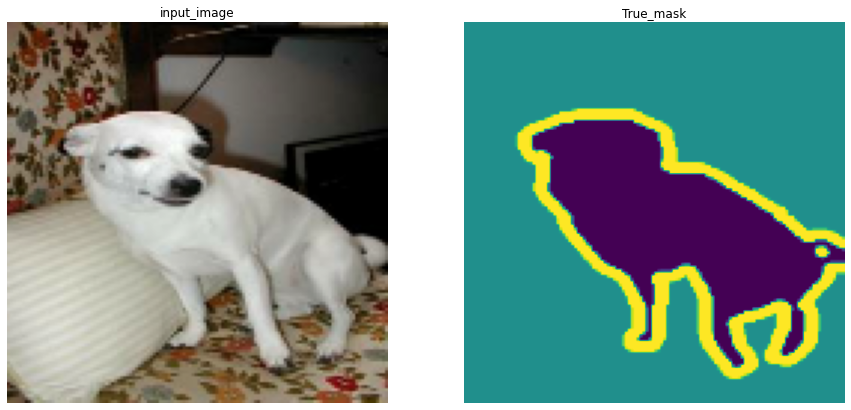

In [9]:
for images, masks in train_baches.take(1):
    sample_image, sample_mask = images[20], masks[20]
    display([sample_image, sample_mask])

##Bounding Boxes

In [10]:
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1
    boxes = tf.stack((center_x, center_y, width, height), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    center_x, center_y, width, height = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = center_x - 0.5 * width
    x2 = center_x + 0.5 * width
    y1 = center_y - 0.5 * height
    y2 = center_y + 0.5 * height

    boxes = tf.stack((x1, y1, x2, y2), axis=-1)
    return boxes


In [11]:
boxes = tf.constant(([25., 10., 95., 95.], [10., 5, 75.5, 80.0]))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [12]:
true_box, pred_box = box_corner_to_center(boxes)
print(true_box.numpy(), pred_box.numpy())

[60.  52.5 70.  85. ] [42.75 42.5  65.5  75.  ]


In [13]:
def boundingbox_to_rect(bbox, color):
    """It draws a bounding box around the object."""
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=3
    )


(-0.5, 127.5, 127.5, -0.5)

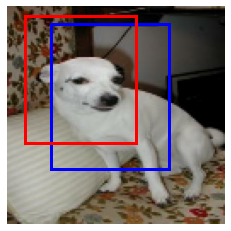

In [14]:
fig = plt.imshow(sample_image)
fig.axes.add_patch(boundingbox_to_rect(boxes[0], 'blue'))
fig.axes.add_patch(boundingbox_to_rect(boxes[1], 'red'))
fig.axes.axis('off')

In [15]:
def intersection_area(box1, box2, box_format=None):
    """Calculates the intersection area of predicted and true bounding boxes."""
    assert box_format, 'You have forgotten \'box_format\' positional argument'

    # Change to corner format if boxes are in center format
    if box_format == "center":
        box1, box2 = box_center_to_corner((box1, box2))

    box1_x1 = box1[..., 0:1]
    box1_y1 = box1[..., 1:2]
    box1_x2 = box1[..., 2:3]
    box1_y2 = box1[..., 3:4]

    box2_x1 = box2[..., 0:1]
    box2_y1 = box2[..., 1:2]
    box2_x2 = box2[..., 2:3]
    box2_y2 = box2[..., 3:4]

    # Get intersection coordinates
    x1 = tf.math.maximum(box1_x1, box2_x1)
    y1 = tf.math.maximum(box1_y1, box2_y1)
    x2 = tf.math.minimum(box1_x2, box2_x2)
    y2 = tf.math.minimum(box1_y2, box2_y2)

    area = tf.clip_by_value((x2 - x1), 0, 1e100) * tf.clip_by_value((y2 - y1), 0, 1e100)
    return area

In [16]:
intersection_area(boxes[0], boxes[1], 'corner').numpy()

array([3535.], dtype=float32)

In [17]:
def intersection_over_union(true_box, predicted_box, box_format=None):
    """Compute IoU 'Intersection over Union' metric."""
    # Check if parameter box_format is not Null
    assert box_format, "missing one positional argument: 'box_format'"
    
    # Calculate intersection area
    intersection = intersection_area(true_box, predicted_box, box_format)

    true_box_x1 = true_box[..., 0:1]
    true_box_y1 = true_box[..., 1:2]
    true_box_x2 = true_box[..., 2:3]
    true_box_y2 = true_box[..., 3:4]

    pred_box_x1 = predicted_box[..., 0:1]
    pred_box_y1 = predicted_box[..., 1:2]
    pred_box_x2 = predicted_box[..., 2:3]
    pred_box_y2 = predicted_box[..., 3:4]

    true_box_area = abs((true_box_x2 - true_box_x1) * (true_box_y2 - true_box_y1))
    pred_box_area = abs((pred_box_x2 - pred_box_x1) * (pred_box_y2 - pred_box_y1))

    return intersection / (true_box_area + pred_box_area - intersection + 1e-6)

In [18]:
intersection_over_union(boxes[1], boxes[0], 'corner')[0].numpy()

0.4824292

In [19]:
# Non max supression
def nms(bboxes, iou_threshold, threshold, box_format='corner'):
    # Bounding Box format: [[class_index, probability, x1, y1, x2, y2], ..., []]
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        
        bboxes = [
                  box 
                  for box in bboxes 
                  if box[0] != chosen_box[0]
                  or intersection_over_union(
                      tf.constant(chosen_box[2:]),
                      tf.constant(box[2:]),
                      box_format=box_format
                  ) < iou_threshold
        ]
        bboxes_after_nms.append(chosen_box)
        
    return bboxes_after_nms

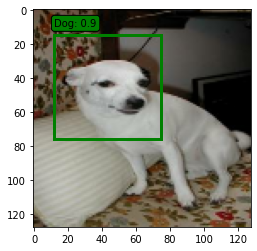

In [20]:
boxes = [[1, 0.9, 12., 14.5, 75., 76.0], [1, 0.84, 15., 17., 87., 79.]]
class_names = {0: 'Cat', 1: 'Dog'}

fig = plt.imshow(sample_image)
for box in nms(boxes, 0.5, 0.5):
    fig.axes.add_patch(
        boundingbox_to_rect(box[2:], 'green')
    )
    fig.axes.annotate('{}: {}'.format(class_names[box[0]], box[1]), xy=(box[2], box[3]-5), bbox=dict(boxstyle="round", fc="green"))

##mAP (mean average Precision) metric implementation

In [21]:
from collections import Counter
import tensorflow_probability as tfp


def mean_average_precision(
    pred_boxes, true_boxes, iou_thershold=0.5, box_format='corner', num_classes=20
):
    # pred_boxes (list): [[train_idx, class_pred, prob_score, x1, y1, x2, y2], ...]
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        # img 0 has 3 bboxes
        # img 1 has 4 bboxes
        # amount_bboxes = {0:3, 1:4}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = tf.zeros(val)
        
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = tf.zeros((len(detections)))
        FP = tf.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]
            num_ground_truth = len(ground_truth_img)
            best_iou = 0 # best iou

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    tf.constant(detection[3:]), tf.constant(gt[3:]), box_format
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx   # Best ground truth index

            if best_iou > iou_thershold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    # This bounding box was covered already
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1
        # True positive cumulative sum
        # [1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = tf.cumsum(TP, axis=0)
        FP_cumsum = tf.cumsum(FP, axis=0)

        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = tf.concat((tf.constant([1.]), precisions), axis=0)
        recalls = tf.concat((tf.constant([0.]), recalls), axis=0)
        average_precisions.append(tfp.math.trapz(precisions, recalls))
    
    return sum(average_precisions) / len(average_precisions)


##You only Look Once (YOLO V1) 

In [22]:
%%writefile yolo_model.py
import tensorflow as tf
import numpy as np

architecture_config = [
    # Tuple: (num_filters, kernel_size, stride, padding)
    (64, 7, 2, 3),
    "M",
    (192, 3, 1, 1),
    "M",
    (128, 1, 1, 0),
    (256, 3, 1, 1),
    (256, 1, 1, 0),
    (512, 3, 1, 1),
    "M",
    [(256, 1, 1, 0), (512, 3, 1, 1), 4],
    (512, 1, 1, 0),
    (1024, 3, 1, 1),
    "M",
    [(512, 1, 1, 0), (1024, 3, 1, 1), 2],
    (1024, 3, 1, 1),
    (1024, 3, 2, 1),
    (1024, 3, 1, 1),
    (1024, 3, 1, 1),
]

class CNNBlock(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.leak_relu = tf.keras.layers.LeakyReLU(0.1)

    def call(self, X):
        return self.leak_relu(self.batch_norm(self.conv(X)))
    

class YoloV1(tf.keras.Model):
    def __init__(self, input_shape_, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.input_shape_ = input_shape_
        self.darknet = self.create_conv_layers(self.architecture)
        self.fcs = self.create_fcs(**kwargs)

    def call(self, X):
        X = self.darknet(X)
        return self.fcs(X)

    def create_conv_layers(self, architecture):
        inputs = tf.keras.layers.Input(shape=self.input_shape_)
        # Custom padding of input layer
        x = tf.pad(inputs, ((0, 0), (3, 3), (3, 3), (0, 0)))

        for item in architecture:
            if type(item) == tuple:
                if item[-1] == 0:
                    x = CNNBlock(
                        filters=item[0], kernel_size=item[1], 
                        strides=item[2]
                    )(x)
                else:
                    x = CNNBlock(
                        filters=item[0], kernel_size=item[1], 
                        strides=item[2], padding='same'
                    )(x)
                
            elif type(item) == str:
                x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                                 strides=2)(x)
            elif type(item) == list:
                conv1 = item[0]
                conv2 = item[1]
                num_repeat = item[2]

                for _ in range(num_repeat):
                    x = CNNBlock(
                        filters=conv1[0], kernel_size=conv1[1], 
                        strides=item[2]
                    )(x)
                    x = CNNBlock(
                        filters=conv2[0], kernel_size=conv2[1], 
                        strides=conv2[2], padding='same'
                    )(x)
        return tf.keras.Model(inputs, x)
    
    def create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(496),    # According to original paper this should be 4096
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LeakyReLU(0.1),
            tf.keras.layers.Dense(S * S * (C + B * 5))  # (S, S, 30) where C = B * 5 = 30
        ])

Writing yolo_model.py


In [23]:
from yolo_model import YoloV1

def test(S=7, B=2, C=20):
    mdl = YoloV1(input_shape_=(448, 448, 3), split_size=S, num_boxes=B, num_classes=C)
    return mdl

my_model = test()
x = tf.random.uniform(shape=(2, 448, 448, 3))
print(my_model(x).shape)
print(my_model.summary())


(2, 1470)
Model: "yolo_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 1024)        44449344  
                                                                 
 sequential (Sequential)     (2, 1470)                 25618382  
                                                                 
Total params: 70,067,726
Trainable params: 70,053,646
Non-trainable params: 14,080
_________________________________________________________________
None


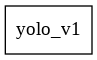

In [24]:
tf.keras.utils.plot_model(my_model)

In [25]:
l = tf.nn.conv2d(tf.ones(shape=(1, 32, 32, 1)),filters=tf.ones((5, 5, 1, 32)), strides=(2, 2), padding=[[0,0], [2, 2], [2, 2], [0,0]])
tuple(l.shape)

(1, 16, 16, 32)

In [26]:
inputs = tf.keras.layers.Input(shape=(32, 32, 1))
custom_padding = tf.pad(inputs, ((0,0), (2, 2), (2, 2), (0,0)))
conv = tf.keras.layers.Conv2D(32, 5, strides=2)(custom_padding)
conv.shape

TensorShape([None, 16, 16, 32])

In [27]:
def _create_layers(input_shape):
    inps = tf.keras.layers.Input(shape=input_shape)
    x = tf.pad(inps, ((0,0), (3,3), (3,3), (0,0)))
    for _ in range(3):
        x = tf.keras.layers.Conv2D(16, 3, strides=2)(x)
    return tf.keras.Model(inps, x)

m = _create_layers((28, 28, 1))
print(m.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 tf.compat.v1.pad_2 (TFOpLam  (None, 34, 34, 1)        0         
 bda)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 16)        160       
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 16)          2320      
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 3, 16)          2320      
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________

In [28]:
from yolo_model import CNNBlock
args  = {'filters': 16, 'kernel_size': 3, 'strides': 2}

CNNBlock(filters=16, kernel_size=3)

In [29]:
act_fcn = tf.nn.leaky_relu
l1 = tf.keras.layers.Dense(1)
l2 = tf.keras.layers.LeakyReLU(0.1)
out = l2(l1(tf.constant([[-2. , -1., 1,], [-1.5, -0.5, 0.7]])))
out.numpy()

array([[0.26219422],
       [0.02943703]], dtype=float32)

In [30]:
class Mymodel:
    
    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(64,kernel_initializer=xavier,activation=tf.nn.relu,input_shape=[1])
        self.l2=tf.keras.layers.Dense(64,kernel_initializer=xavier,activation=tf.nn.relu)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adagrad(learning_rate=0.1)
        
    # Running the model
    def run(self,X):
        return self.out(self.l2(self.l1(X)))
      
    #Custom loss fucntion
    def get_loss(self,X,Y):
        y_hat = self.out(self.l2(self.l1(X)))
        return tf.math.square(y_hat-Y)
      
    # get gradients
    def get_grad(self,X,Y):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(X,Y)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.out.variables[0],self.out.variables[1]])
        return g, L
      
    # perform gradient descent
    def network_learn(self,X,Y):
        g, loss = self.get_grad(X,Y)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.out.variables[0],self.out.variables[1]]))
        return tf.math.reduce_mean(loss)

In [31]:
import numpy as np

x=[1,2,3,4,5,6,7,8,9,10]
x=np.asarray(x,dtype=np.float32).reshape((10,1))
y=[1,4,9,16,25,36,49,64,81,100]
y=np.asarray(y,dtype=np.float32).reshape((10,1))
model=Mymodel()
for i in range(100):
    loss_value = model.network_learn(x,y)
    print("Epoch: {},\tLoss: {}".format(i+1, loss_value))

Epoch: 1,	Loss: 2500.24462890625
Epoch: 2,	Loss: 1280.8372802734375
Epoch: 3,	Loss: 214.29776000976562
Epoch: 4,	Loss: 370.23211669921875
Epoch: 5,	Loss: 558.0473022460938
Epoch: 6,	Loss: 669.2112426757812
Epoch: 7,	Loss: 178.2563934326172
Epoch: 8,	Loss: 170.843505859375
Epoch: 9,	Loss: 165.99911499023438
Epoch: 10,	Loss: 161.6798858642578
Epoch: 11,	Loss: 157.65719604492188
Epoch: 12,	Loss: 153.79400634765625
Epoch: 13,	Loss: 150.0391082763672
Epoch: 14,	Loss: 146.38955688476562
Epoch: 15,	Loss: 142.8179931640625
Epoch: 16,	Loss: 139.30886840820312
Epoch: 17,	Loss: 135.8861083984375
Epoch: 18,	Loss: 132.53671264648438
Epoch: 19,	Loss: 129.24160766601562
Epoch: 20,	Loss: 126.02122497558594
Epoch: 21,	Loss: 122.8756332397461
Epoch: 22,	Loss: 119.77436828613281
Epoch: 23,	Loss: 116.7162857055664
Epoch: 24,	Loss: 113.7004623413086
Epoch: 25,	Loss: 110.73344421386719
Epoch: 26,	Loss: 107.85575866699219
Epoch: 27,	Loss: 105.01927185058594
Epoch: 28,	Loss: 102.22441101074219
Epoch: 29,	Loss

In [102]:
def tf_flatten(tf_tensor, end_dim=None):
    """
        Flats the input tensor, if end_dim is positive flats 
    the first part until the end_dim and keep the second part,
    if end_dim is negative keeps the first part and flats the second part,
    if end_dim is None or -1 flats the whole tensor.
    """
    from tensorflow.python.ops.math_ops import reduce_prod
    import tensorflow as tf
    assert isinstance(tf_tensor, tf.Tensor)
    tensor_shape = tf_tensor.shape
    if end_dim and end_dim != -1:
        if end_dim < 0:
            new_shape = [
                         tf.reduce_prod(tensor_shape[:end_dim+1]).numpy()
                         ] + tensor_shape[end_dim+1:]
            return tf.reshape(tf_tensor, new_shape)
        else:
            new_shape = tensor_shape[:end_dim] + [
                tf.reduce_prod(tensor_shape[end_dim:]).numpy()
            ]
            return tf.reshape(tf_tensor, new_shape)
    
    else:
        return tf.reshape(tf_tensor, [-1])

In [111]:
%%writefile loss.py

import tensorflow as tf
from tensorflow.keras import losses
import numpy as np

class YoloLoss(losses.Loss):
    def __init__(self, S=7, B=2, C=20, name='yolo_loss'):
        super().__init__(name=name)
        self.mse = losses.MeanSquaredError(reduction=losses.Reduction.SUM)
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 5
        self.lambda_noobj = 0.5

    def call(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 26:30])
        ious = tf.concat([tf.expand_dims(iou_b1, 0), tf.expand_dims(iou_b2, 0)], axis=0)
        ious_maxes, best_box = tf.maximum(ious[0], ious[1]), tf.argmax(ious, axis=0)
        exists_box = tf.expand_dims(target[..., 20], 3)     # I_obj_i

        #=========================#
        #   FOR BOX COORDINATES   #
        #=========================#
        box_predictions = exists_box * (
            best_box * predictions[..., 26:30]
            + (1 - best_box) * predictions[..., 21:25]
        )

        box_targets = exists_box * target[..., 21:25]

        box_predictions[..., 2:4] = tf.sign(box_predictions[..., 2:4]) * tf.sqrt(
            tf.abs(box_predictions[..., 2:4]) + 1e-6)

        box_targets[..., 2:4] = tf.sqrt(box_targets[..., 2:4])
        # (N, S, S, 4) -> (N*S*S, 4)
        box_loss = self.mse(
            tf_flatten(box_predictions, end_dim=-2), 
            tf_flatten(box_targets, end_dim=-2)
        )

        #======================#
        #    FOR OBJECT LOSS   #
        #======================#
        # (N*S*S)
        pred_box = (
            best_box * predictions[... , 25:26] + (1 - best_box) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            tf_flatten(exists_box * pred_box),
            tf_flatten(exists_box * target[..., 20:21])
        )

        #====================#
        #   NO OBJECT LOSS   #
        #====================#
        # (N, S, S, 1) -> (N, S*S)
        noobj_loss = self.mse(
            tf_flatten((1 - exists_box) * predictions[..., 20:21], end_dim=1),
            tf_flatten((1 - exists_box) * target[..., 20:21])
        )

        noobj_loss += self.mse(
            tf_flatten((1 - exists_box) * predictions[..., 25:26], end_dim=1),
            tf_flatten((1 - exists_box) * target[..., 20:21])
        )

        #====================#
        #   FOR CLASS LOSS   #
        #====================#

        # (N, S, S, 20) -> (N*S*S, 20)
        class_loss = self.mse(
            tf_flatten(exists_box * predictions[..., :20], end_dim=-2),
            tf_flatten(exists_box * target[..., :20], end_dim=-2)
        )

        # Total Yolo Loss
        loss = (
            self.lambda_coord * box_loss    # First two rows in the paper
            + object_loss
            + self.lambda_noobj * noobj_loss
            + class_loss
        )

        return loss


Writing loss.py


In [32]:
iou_b1 = tf.random.uniform((1, 7, 7, 1), 0, 1, seed=0)
iou_b2 = tf.random.uniform((1, 7, 7, 1), 0, 1, seed=0)
ious = tf.concat([tf.expand_dims(iou_b1, 0), tf.expand_dims(iou_b2, 0)], axis=0)
maxes, indices = tf.maximum(ious[0], ious[1]), tf.argmax(ious, axis=0)
print(maxes.shape, indices.shape)


(1, 7, 7, 1) (1, 7, 7, 1)


In [110]:
target = tf.random.uniform((50, 7, 7, 30), 0, 1)
tf_flatten(target, 1).shape

TensorShape([50, 1470])